# Chi Square Test


https://passel2.unl.edu/view/lesson/9beaa382bf7e/8#:~:text=If%20your%20chi%2Dsquare%20calculated,to%20reject%22%20your%20null%20hypothesis.

If your chi-square calculated value is greater than the chi-square critical value, then you reject your null hypothesis.
Rejecting hypothesis means we assume something other than chance was at play.

In [1]:
chi_square_value=6.35 # value for 0.01 configence (should only occur in 0.01 of all cases other than by chance)

In [2]:
import pandas as pd


exact_matches = pd.read_parquet("../results/artists_exact_match_large.parquet", engine='pyarrow')
assert "artists" in exact_matches.columns, f'artists is not in {exact_matches.columns}'
assert "num_artists" in exact_matches.columns, f'num_artists is not in {exact_matches.columns}'

print(f'exact match shapes {exact_matches.shape}')

# read excel_artist_names
import my_utils

excel_artist_names = my_utils.read_lines_as_list("../sources/excel_artists_copy_paste_name.txt")
hundred_artist_names = excel_artist_names[0:100]
ten_artist_names = excel_artist_names[0:10]


artist_mentions = pd.read_parquet('../results/artist_mentions.parquet', engine='pyarrow')
artist_mentions.sort_values(["mentions"], inplace=True, ascending=False)

exact match shapes (1819808, 5)


In [3]:
import wordcloud
from collections import defaultdict
import re

def read_stopwords():
    # from https://gist.github.com/sebleier/554280
    return my_utils.read_lines_as_list("stopwords.txt")

def compute_freq(df, col, sw):
    # print(sw)
    freq = defaultdict(lambda: 0)
    for i, row in df.iterrows():
        string = row[col]
        for s in re.split("[, \-!?:\.]+", string):
            s=s.strip().lower()
            if s not in sw:
                if len(s)>0:
                    freq[s]=freq[s]+1
    return freq



In [4]:
stopwords=read_stopwords()
stopwords.append("greg")
stopwords.append("rutkowski")

freqs = compute_freq(exact_matches, "prompt", stopwords)
print(f'finished')

greg_df = my_utils.exact_match_dataframe(exact_matches, "greg rutkowski")
freqs_greg = compute_freq(greg_df, "prompt", stopwords)
print(f'finished')

finished
finished


In [5]:

import chi_values as cv

print(f'{len(freqs.keys())} items in plain, {len(freqs_greg.keys())} items in greg')

chi_values = cv.chi_value_dataframe(freqs, freqs_greg)

print(f'amount of queries for greg {greg_df.shape[0]}')
print(greg_df.head().prompt.values)

print(f'amount of words with higher than threshold chi value: {chi_values[chi_values["chi_values"]>=chi_square_value].shape[0]}')

print(chi_values.head(40))


202121 items in plain, 43376 items in greg
amount of queries for greg 180080
['rimworld concept art isometric perspective, epic, by victo ngai, kilian eng vibrant colours, dynamic lighting, digital art, winning award masterpiece, fantastically beautiful, illustration, inspired by beksinski and dan mumford, trending on artstation, by greg rutkowski, 8 k '
 'realistic streetview, retro futuristic suburban scene, brutal architecture, straight edged buildings, street signs, detailed shop facades, neon signs, video screens, traffic lights, street lights, pedestrians, jodhpurs greg manchess painting by sargent and leyendecker, cyberpunk 2 0 7 7 concept intricate elegant illustration forza, by greg rutkowski by greg tocchini by james gilleard '
 'street scene, brutal architecture, retro futuristic concept cars, low profile tires, detailed chrome trim, jodhpurs greg manchess painting by sargent and leyendecker, cyberpunk 2 0 7 7 concept intricate elegant illustration forza, by greg rutkowski b

# Cluster Artists by Chi Square Values

First we need to find out which words to use for the artist features.
For this we can use the words ranked by chi values for the individual artists.

In [ ]:
import copy

#artists = ["greg rutkowski", "trending on artstation", "artgerm", "alphonse mucha", "wlop", "ilya kuvshinov", "makoto shinkai", "james jean", "beeple", "moebius"]
num_artists = 20
artists = artist_mentions.head(num_artists).artist.values

stopwords=read_stopwords()
for a in artists:
    stopwords.extend(a.lower().split(" "))

# TODO add all artist names to the stopword list?
    
    
print(f'stopwords {stopwords}')

print(f'exact_matches shape {exact_matches.shape}')

freqs_all = compute_freq(exact_matches, "prompt", stopwords)
for index, artist in enumerate(artists):
    
    artist_df = my_utils.exact_match_dataframe(exact_matches, artist)
    #print(artist_df.shape)
    assert artist_df.shape[0]>0, f'no match found for {artist}'
    freqs_artist = compute_freq(artist_df, "prompt", stopwords)
    
    frequencies_other = copy.deepcopy(freqs_all)
    #print(f'cannonsiin counts other {freqs_all["cannonsiin"]}')
    for key, value in frequencies_other.items():
        #if value == 0:
            #print(f'{key} {value}')
        assert value > 0, f'value must be bigger than 0 since we go over all prompts, word {key}'
        assert frequencies_other[key] >= freqs_artist[key], f'frequency of {key} in entire should be higher or equal to specific, {frequencies_other[key]} {freqs_artist[key]}'
        frequencies_other[key] = max(frequencies_other[key] - freqs_artist[key], 0)
    
    artist_chi_df = cv.chi_value_dataframe(frequencies_other, freqs_artist)
    #chi_df.drop(["word_frequency"], axis=1, inplace=True)
    artist_chi_df.rename({"word_frequency": f'frequency_{artist}',"chi_values": f'chi_values_{artist}', "word": f'word_{artist}'}, axis='columns', inplace=True)
    
    if index == 0:
        chi_df = artist_chi_df.copy()
    else:
        chi_df = pd.concat([chi_df, artist_chi_df], axis=1)

        
print(chi_df.shape)        
print(chi_df.head())



In [7]:
n_features = 10
features = []
for index, series in chi_df.iterrows():
    if len(features) > n_features:
        break
    for artist in artists:
        word = series[f'word_{artist}']
        if word not in features:
            features.append(word)
            print(f'added {word} via {artist}')
        
print(features)
feature_df = pd.DataFrame(columns=features)

for artist in artists:
    chi_values = {}
    for f in features:
        feature_row = chi_df[chi_df[f'word_{artist}']==f]
        v = feature_row[f'chi_values_{artist}'].item()
        chi_values[f] = v

    # Add row to the DataFrame using append()
    feature_df = feature_df.append(pd.Series(chi_values, index=feature_df.columns, name=artist))

print(feature_df.shape)
print(feature_df.head())

added art via Greg Rutkowski
added archdaily via Trending on artstation
added focus via Artgerm
added riabovitchev via WLOP
added rossdraws via Ilya Kuvshinov
added tooth via Beeple
added giraud via Moebius
added gaston via Craig Mullins
added alen via Peter Mohrbacher
added mandy via Ruan Jia
added knab via Tom Bagshaw
added doizon via Ross Tran
added ejsing via RHADS
added demura via Krenz Cushart
added kindkade via Norman Rockwell
['art', 'archdaily', 'focus', 'riabovitchev', 'rossdraws', 'tooth', 'giraud', 'gaston', 'alen', 'mandy', 'knab', 'doizon', 'ejsing', 'demura', 'kindkade']


/tmp/ipykernel_3266432/1582884568.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append(pd.Series(chi_values, index=feature_df.columns, name=artist))
/tmp/ipykernel_3266432/1582884568.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append(pd.Series(chi_values, index=feature_df.columns, name=artist))
/tmp/ipykernel_3266432/1582884568.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append(pd.Series(chi_values, index=feature_df.columns, name=artist))
/tmp/ipykernel_3266432/1582884568.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feat

(20, 15)
                                  art     archdaily          focus  \
Greg Rutkowski           92723.773423    548.914609   67169.871327   
Trending on artstation    6724.250179  19826.013679      20.779745   
Artgerm                  88510.157560    425.184170  101812.112731   
Alphonse Mucha          108931.115115    239.781101  107518.157096   
WLOP                     13752.444398    201.011105   12133.604149   

                        riabovitchev     rossdraws         tooth      giraud  \
Greg Rutkowski            254.229839   2240.522313  13903.046659  458.605789   
Trending on artstation   7946.310772   1813.326119   1177.397490   76.139181   
Artgerm                 34560.373541  30369.218758    410.809319  126.104542   
Alphonse Mucha             38.616775    359.290693    283.504774   53.554093   
WLOP                    69417.372697  40683.394467  56537.030387  184.939063   

                             gaston          alen        mandy          knab  \
Greg Rutk

/tmp/ipykernel_3266432/1582884568.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_df = feature_df.append(pd.Series(chi_values, index=feature_df.columns, name=artist))


## Clustering


We cluster normalized Data.
We use 2 pandas visualizations (radviz and parallel_coordinates).
We then also reduce the dimensionality to 2 with PCA to plot the data in 2D.

                                  art     archdaily          focus  \
Greg Rutkowski           92723.773423    548.914609   67169.871327   
Trending on artstation    6724.250179  19826.013679      20.779745   
Artgerm                  88510.157560    425.184170  101812.112731   
Alphonse Mucha          108931.115115    239.781101  107518.157096   
WLOP                     13752.444398    201.011105   12133.604149   
Ilya Kuvshinov            1569.955911     47.390147      97.998379   
Makoto Shinkai            1196.473754     92.965783     802.750357   
James Jean                   1.089725     75.577864      78.503686   
Beeple                     381.593958     32.001262     459.895118   
Moebius                    299.165488     57.647491     230.171284   
Craig Mullins               50.249428     48.823697      18.269473   
Peter Mohrbacher             3.474975     56.280643     221.405945   
Ruan Jia                  1013.458589     54.519990     675.655513   
Tom Bagshaw         

/home/sc.uni-leipzig.de/gf346tmau/.conda/envs/my_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/sc.uni-leipzig.de/gf346tmau/.conda/envs/my_env/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/home/sc.uni-leipzig.de/gf346tmau/.conda/envs/my_env/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


           0         1
0  -1.635149  2.180357
1  -0.706212 -0.839610
2  -1.888537  2.737735
3  -2.248313  3.256936
4  -0.642521 -0.352809
5   1.243651 -0.281008
6   1.252051 -0.308689
7  -0.251620 -0.603436
8  -0.719827 -1.023661
9  -0.550786 -1.201135
10 -0.588940 -1.207874
11 -0.687883 -1.135298
12 -0.683678 -0.860720
13  0.476965 -0.690664
14 -0.575151 -1.187602
15  4.112864  1.354630
16 -0.929877 -0.092751
17  4.432005  1.505501
18  0.980436 -0.603718
19 -0.389478 -0.646185


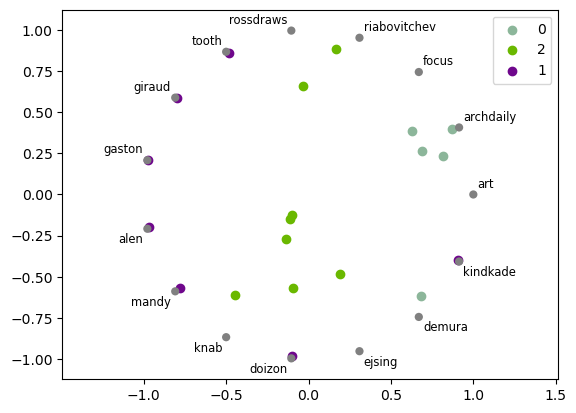

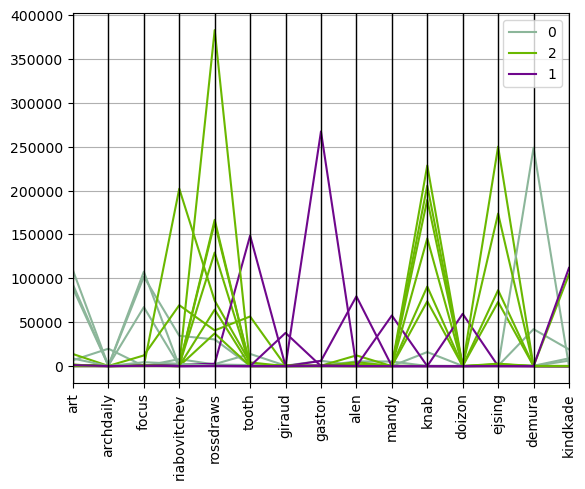

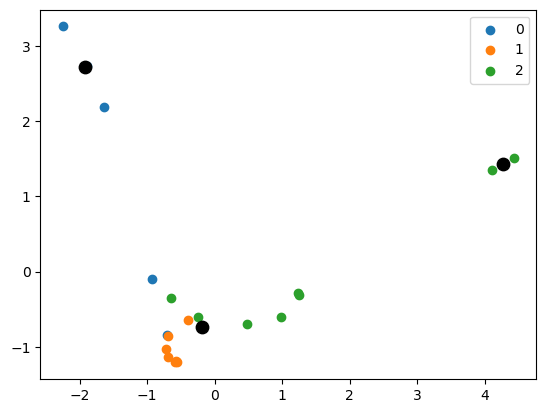

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn import preprocessing
normalized_features = feature_df.copy()
for col in normalized_features.columns:
    normalized_features[col]=normalized_features[col].apply(lambda x: (x-normalized_features[col].mean()) / normalized_features[col].std())
#print(feature_df)
#print("normalized:")
#print(normalized_features)


kmeans = KMeans(n_clusters=3)

features_clustering = normalized_features.values
print(features_clustering.shape)

print(f'{features_clustering.shape} should be (n_samples, n_features)')

kmeans.fit(features_clustering)

#Getting the Centroids
centroids = kmeans.cluster_centers_

predict = kmeans.predict(feature_df)
feature_df['cluster'] = predict

for cluster in feature_df.cluster.unique():
    print(f'{cluster} consists of')
    print(feature_df[feature_df['cluster'] == cluster].index.values)

from pandas.plotting import radviz
radviz(feature_df, "cluster")
# https://pandas.pydata.org/docs/user_guide/visualization.html#radviz

plt.figure()
plt.xticks(rotation=90)
pd.plotting.parallel_coordinates(feature_df, 'cluster')


plt.figure()
#normalized_features['cluster'] = predict

from sklearn.decomposition import PCA as sklearnPCA
pca = sklearnPCA(n_components=2)
transformed = pd.DataFrame(pca.fit_transform(normalized_features))
centroids_pca = pca.transform(centroids)

print(transformed)

#plotting the results:
# http://www.apnorton.com/blog/2016/12/19/Visualizing-Multidimensional-Data-in-Python/
for index, centroid in enumerate(centroids):
    plt.scatter(transformed[predict == index][ 0] , transformed[predict == index][1] , label = index)
plt.scatter(centroids_pca[:,0] , centroids_pca[:,1] , s = 80, color = 'black')
plt.legend()
plt.show()






